# VANA Assignment - Gradient Descent

## Aufgabenstellung
Das Ziel dieser Aufgabe besteht darin, dass Sie ein grundlegendes Verständnis für numerische Näherungsverfahren in höheren Dimensionen erlangen, insbesondere für den Gradient Descent und dessen praktische Anwendung. Hierfür sollen Sie ein Jupyter Notebook erstellen und das MNIST Dataset laden und erkunden. Anschliessend sollen Sie ein neuronales Netzwerk erstellen und trainieren, um die Bilder korrekt zu klassifizieren. Es dürfen nur die angegebenen Python Pakete verwendet werden.

In [156]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision.datasets import MNIST 


## Aufgabe 1

Laden Sie das MNIST-Dataset (Training und Test) mithilfe des torchvision-Pakets (Verwenden Sie das torchvision Paket nur für diese Aufgabe) und verwenden Sie matplotlib, um sich einen Überblick über die Daten zu verschaffen. Beschreiben Sie die grundlegenden Eigenschaften des Datensets, z.B. wie viele und welche Daten es enthält und wie diese verteilt sind.

Anzahl der Trainingsbilder: 60000
Anzahl der Testbilder: 10000
Grösse der Bilder: (28, 28)


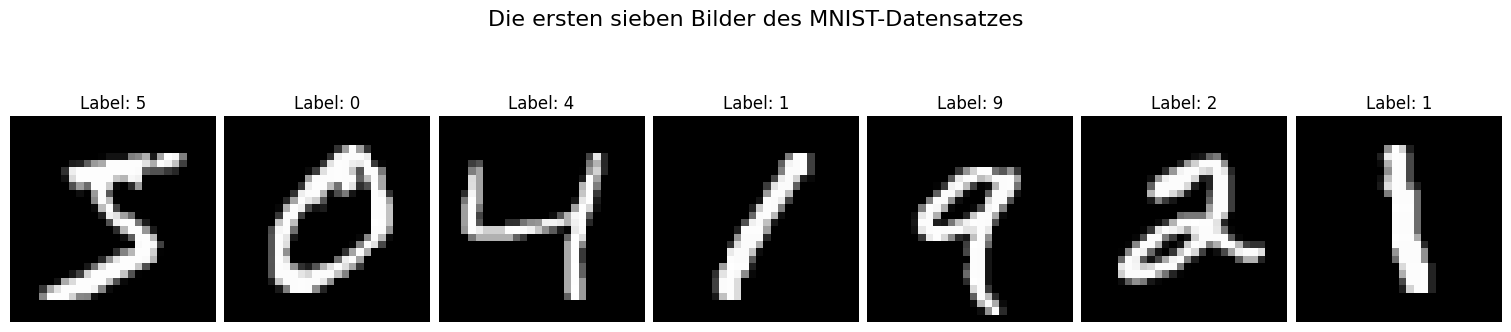

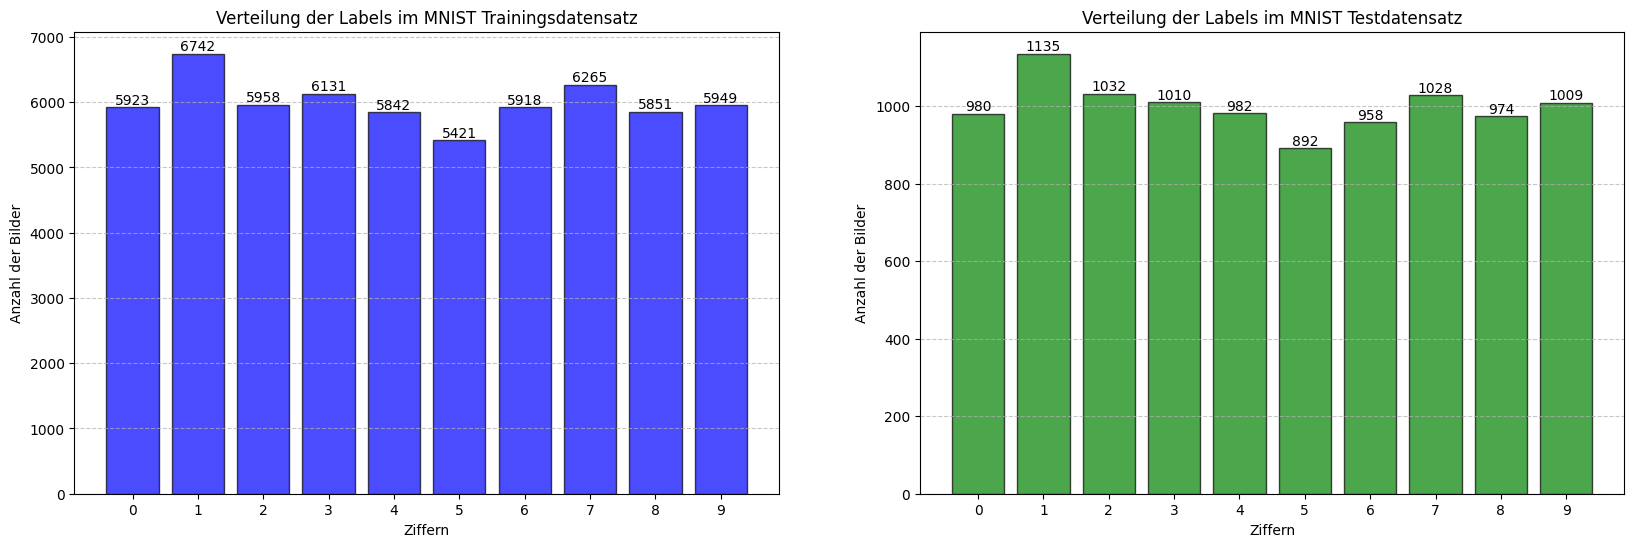

In [157]:
mnist_train = MNIST(root='./data', train=True, download=True)
mnist_test = MNIST(root='./data', train=False, download=True)

train_data = mnist_train.data.numpy()
train_labels = mnist_train.targets.numpy()
test_data = mnist_test.data.numpy()
test_labels = mnist_test.targets.numpy()

print(f'Anzahl der Trainingsbilder: {len(train_data)}')
print(f'Anzahl der Testbilder: {len(test_data)}')
print(f'Grösse der Bilder: {train_data[0].shape}')

# Example images

fig, axes = plt.subplots(1, 7, figsize=(15, 4), constrained_layout=True)
for i, ax in enumerate(axes):
    ax.imshow(train_data[i], cmap='gray')
    ax.title.set_text(f'Label: {train_labels[i]}')
    ax.axis('off')
plt.suptitle('Die ersten sieben Bilder des MNIST-Datensatzes', fontsize=16)

# Distribution of the Data

fig, axes = plt.subplots(1, 2, figsize=(20, 6)) 
train_counts = np.bincount(train_labels)
test_counts = np.bincount(test_labels)

bars_train = axes[0].bar(np.arange(10), train_counts, color='blue', alpha=0.7, edgecolor='black')
axes[0].set_title('Verteilung der Labels im MNIST Trainingsdatensatz')
axes[0].set_xlabel('Ziffern')
axes[0].set_ylabel('Anzahl der Bilder')
axes[0].bar_label(bars_train)
axes[0].set_xticks(np.arange(10))
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

bars_test = axes[1].bar(np.arange(10), test_counts, color='green', alpha=0.7, edgecolor='black')
axes[1].set_title('Verteilung der Labels im MNIST Testdatensatz')
axes[1].set_xlabel('Ziffern')
axes[1].set_ylabel('Anzahl der Bilder')
axes[1].bar_label(bars_test)
axes[1].set_xticks(np.arange(10))
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


**Eigenschaften des MNIST-Datensatzes:**

* Der Datensatz enthält 70.000 Bilder wovon
    * 60.000 Trainingsbilder und
    * 10.000 Testbilder sind
* Alle Bilder haben die Grösse von (28x28) Pixel und sind Schwarz / Weiss
* Auf den Histogrammen ist gut zu erkennen, dass die Daten regelmässig und gleichmässig verteilt sind und es keine grossen Ausreisser gibt.
* Die Verteilung der Labels im MNIST Testdatensatz weicht in der prozentualen Verteilung nur leicht der Verteilung der Labels im MNIST Trainingsdatensatz ab.
* Zu jeder handgeschriebenen Ziffern gibt es ein passendes Label, welche Ziffer das Bild darstellt.

## Aufgabe 2

Erstellen Sie eine Klasse für ein lineares Layer mit beliebig vielen Knoten. Implementieren Sie darin getrennte Methoden für Forward-Pass, Backward-Pass und Parameter-Update mithilfe von numpy. Schreiben Sie geeignete Unittests, um die Funktionsweise dieser Funktionen zu prüfen. Schreiben Sie insbesondere einen expliziten Test, für ein Layer mit 2 Knoten, welches als Input 2 Datensätzen zu je zwei 2 floats erhält. Wählen Sie dazu unterschiedliche feste Werte für Input, initiale Gewichte und Lernrate. Dann berechnen sie von Hand die Ergebnisse von Forward, Backward und Update und testen damit ihre Implementation. Legen Sie die Berechnung der Ergebnisse ihrer Lösung bei.

### Aufbau des Linear Layers

Hier wird der Lineare Layer aufgebaut. Dieser unterstützt die Funktionen Forward-Pass, Backwards-Pass und Parameter-Update. In den nachfolgenden Kapiteln werden diese Funktionen durch ihre mathematischen Definitionen beschrieben.
<br>

#### Forward-Pass

**Input**: Matrix von N Datenpunkten mit I Dimensionen

$$N: \text{Anzahl der Datenpunkte} = 60000 $$
$$I: \text{Anzahl der Datenpunkte in einem Datenpunkt} = 28 \cdot 28 = 784 $$
$$X: N \times I = 60000 \times 784 $$

**Output**: Matrix der N mit O Dimensionen
$$O: \text{Outputwerte pro Punkt / Kerne / Knoten} $$
$$z: N \times O $$

**Implementation**: Vektorschreibweise 
$$z = x \cdot w + b $$
$$\text{Gewichte}\ w: 1 \times O\ \text{Matrix} $$
$$\text{Biases}\ b: O \text{ Vektor}\ \rightarrow (1,0)\text{Matrix} $$
$$\text{beides im self} $$

Komponentenschreibweise:
$$i: \text{Index des Datensatz} $$
$$l: \text{index des Outputs} $$
$$z_{il} = \sum_{k=1}^{I} (x_{ik} \cdot w_{kl} + b_l) $$

#### Backward-Pass

**Input**: Ableitung des Loss nach dem Output des Layers
$$\frac{\partial Loss}{\partial z}: N \times O \text{ Matrix}$$

**Output**: Ableitung des Loss nach den Parametern $w$, $b$ sowie nach Input $x$
$$db: O \text{ Vektor} \rightarrow (1,0)\text{Matrix} = \frac{\partial Loss}{\partial b} = \frac{\partial Loss}{\partial z} \frac{\partial z}{\partial b}$$
$$dw: I \times O \text{ Matrix} = \frac{\partial Loss}{\partial w} = \frac{\partial Loss}{\partial z} \frac{\partial z}{\partial w}$$
$$dx: N \times I \text{ Matrix} = \frac{\partial Loss}{\partial x} = \frac{\partial Loss}{\partial z} \frac{\partial z}{\partial x}$$

**Implementation**: $dx$ ausgeben, $dw$ und $db$ im self speichern
$$db = \frac{\partial Loss}{\partial z} \frac{\partial z}{\partial b} = \sum_{i=1}^N \frac{\partial Loss}{\partial z}$$
$$dw = \frac{\partial Loss}{\partial z} \frac{\partial z}{\partial w} = X^T \frac{\partial Loss}{\partial z}$$
$$dx = \frac{\partial Loss}{\partial z} \frac{\partial z}{\partial x} = \frac{\partial Loss}{\partial z} W^T \text{ da gilt}:\frac{\partial z}{\partial x} = W^T$$

#### Parameter-Update

**Input**: Ableitungen des Loss nach den Parametern und Lernrate

$$\alpha: Lernrate$$

**Output**: Veränderte Parameter

$$w \rightarrow w - \alpha \frac{\partial Loss}{\partial w}$$
$$b \rightarrow b - \alpha \frac{\partial Loss}{\partial b}$$

**Implementation**: Parameter und Ableitung werden in einer Klasse gespeichert. Die Update Funktion beinhaltet keinen expliziten Output, der Input ist lediglich die Lernrate

$$w = w - \alpha\ dw$$
$$b = b - \alpha\ db$$

In [158]:
class LinearLayer:
    """
    Represents a linear layer in a neural network, performing linear transformation
    using weights and biases.

    Attributes:
        input_data (np.ndarray): The last input received during the forward pass.
        output (np.ndarray): The result from the last forward pass.
        weights (np.ndarray): Weights matrix, initialized randomly.
        biases (np.ndarray): Biases vector, initialized to zero.
        grad_weights (np.ndarray): Gradient of weights from the last backward pass.
        grad_biases (np.ndarray): Gradient of biases from the last backward pass.
    """
    
    def __init__(self, input_size: int, output_size: int) -> None:
        """
        Initializes the layer with random weights and zero biases.
        
        Args:
            input_size (int): The size of the input data.
            output_size (int): The size of the output data.
        """
        self.input_data = None
        self.output = None
        self.weights = np.random.randn(output_size, input_size) / np.sqrt(input_size)
        self.biases = np.zeros((output_size, 1))
        self.grad_weights = None
        self.grad_biases = None
    
    def forward_pass(self, input_data: np.ndarray) -> np.ndarray:
        """
        Computes the output of the layer for a given input.

        Args:
            input_data (np.ndarray): The input data to the layer. Shape: (input_size, n).

        Returns:
            np.ndarray: The output of the layer. Shape: (output_size, n).
        """
        self.input_data = input_data
        self.output = np.dot(self.weights, input_data) + self.biases
        return self.output
    
    def backward_pass(self, grad_output: np.ndarray) -> np.ndarray:
        """
        Computes gradients for weights and biases and the gradient for the input.

        Args:
            grad_output (np.ndarray): Gradient of the loss with respect to the output of this layer.

        Returns:
            np.ndarray: Gradient of the loss with respect to the input of this layer.
        """
        grad_input = np.dot(self.weights.T, grad_output)
        self.grad_weights = np.dot(grad_output, self.input_data.T)
        self.grad_biases = np.sum(grad_output, axis=1, keepdims=True)
        return grad_input
    
    def parameter_update(self, learning_rate: float) -> None:
        """
        Updates the weights and biases based on their gradients.

        Args:
            learning_rate (float): The step size to use for the update.
        """
        self.weights -= learning_rate * self.grad_weights
        self.biases -= learning_rate * self.grad_biases


## Tests für den Linear Layer

Um sicherzustellen, dass der Linear Layer wie erwartet funktioniert, wird seine Funktionalität durch Unit-Tests überprüft. Die ersten drei Unit-Tests überprüfen das grundlegende Verhalten der Funktionen, während der letzte Test den Linear Layer anhand eines konkreten Zahlenbeispiels validiert. Die manuelle Berechnung für dieses Beispiel ist unten angehängt.
<br>

### Expliziter Test

Berechnung des Forwards:

$$ W = \begin{bmatrix} 0.1 & 0.2 \\ 0.3 & 0.4 \end{bmatrix} $$
$$ b = \begin{bmatrix} 0.5 \\ 0.6 \end{bmatrix} $$
$$ X = \begin{bmatrix} 0.7 & 0.8 \\ 0.9 & 1.0 \end{bmatrix} $$ 
$$ 
\text{output} = W \cdot X + b = 
\begin{bmatrix} 0.1 & 0.2 \\ 0.3 & 0.4 \end{bmatrix} \cdot \begin{bmatrix} 0.7 & 0.8 \\ 0.9 & 1.0 \end{bmatrix} + \begin{bmatrix} 0.5 \\ 0.6 \end{bmatrix} = 
\begin{bmatrix} 0.25 & 0.28 \\ 0.57 & 0.64 \end{bmatrix} + \begin{bmatrix} 0.5 \\ 0.6 \end{bmatrix} =
\begin{bmatrix} 0.75 & 0.78 \\ 1.17 & 1.24 \end{bmatrix}
$$

Berechnung des Backwards:

$$ \text{grad output} = \begin{bmatrix} 0.1 & 0.2 \\ 0.3 & 0.4 \end{bmatrix} $$
$$ 
\text{grad input} = W^T \cdot \text{input data} = 
\begin{bmatrix} 0.1 & 0.3 \\ 0.2 & 0.4 \end{bmatrix} \cdot \begin{bmatrix} 0.1 & 0.2 \\ 0.3 & 0.4 \end{bmatrix} =
\begin{bmatrix} 0.1 & 0.14 \\ 0.14 & 0.2 \end{bmatrix}
$$

Berechnung des Parameter Updates:

$$ 
\text{grad weights} = \text{grad output} \cdot X^T =
\begin{bmatrix} 0.1 & 0.2 \\ 0.3 & 0.4 \end{bmatrix} \cdot \begin{bmatrix} 0.7 & 0.9 \\ 0.8 & 1.0 \end{bmatrix} =
\begin{bmatrix} 0.86 & 0.29 \\ 0.53 & 0.67 \end{bmatrix}
$$
$$ 
\text{grad biases} = \begin{bmatrix} \sum \text{grad output}_{1j} \\ \sum \text{grad output}_{2j} \end{bmatrix} = 
\begin{bmatrix} 0.3 \\ 0.7 \end{bmatrix}
$$
$$ \text{learning rate} = 0.1 $$
$$
W_{updated} = W - \text{learning rate} \cdot \text{grad weights} =
\begin{bmatrix} 0.1 & 0.2 \\ 0.3 & 0.4 \end{bmatrix} - 0.1 \cdot \begin{bmatrix} 0.86 & 0.29 \\ 0.53 & 0.67 \end{bmatrix} =
\begin{bmatrix} 0.077 & 0.171 \\ 0.247 & 0.333 \end{bmatrix}
$$
$$
b_{updated} = b - \text{learning rate} \cdot \text{grad biases} =
\begin{bmatrix} 0.5 \\ 0.6 \end{bmatrix} - 0.1 \cdot \begin{bmatrix} 0.3 \\ 0.7 \end{bmatrix} =
\begin{bmatrix} 0.47 \\ 0.63 \end{bmatrix}
$$

### Unit-Tests

In [159]:
import unittest

class TestLinearLayer(unittest.TestCase):
    def test_forward_pass(self):
        layer = LinearLayer(2, 2)
        layer.weights = np.array([[0.1, 0.2], [0.3, 0.4]])
        layer.biases = np.array([[0.5], [0.6]])
        input_data = np.array([[0.7, 0.8], [0.9, 1.0]])
        expected_output = np.dot(layer.weights, input_data) + layer.biases
        np.testing.assert_array_almost_equal(layer.forward_pass(input_data), expected_output, decimal=5)

    def test_backward_pass(self):
        layer = LinearLayer(2, 2)
        layer.weights = np.array([[0.1, 0.2], [0.3, 0.4]])
        layer.biases = np.array([[0.5], [0.6]])
        input_data = np.array([[0.7, 0.8], [0.9, 1.0]])
        layer.forward_pass(input_data)
        grad_output = np.array([[0.1, 0.2], [0.3, 0.4]])
        expected_grad_input = np.dot(layer.weights.T, grad_output)
        np.testing.assert_array_almost_equal(layer.backward_pass(grad_output), expected_grad_input, decimal=5)

    def test_parameter_update(self):
        layer = LinearLayer(2, 2)
        layer.weights = np.array([[0.1, 0.2], [0.3, 0.4]])
        layer.biases = np.array([[0.5], [0.6]])
        input_data = np.array([[0.7, 0.8], [0.9, 1.0]])
        layer.forward_pass(input_data)
        grad_output = np.array([[0.1, 0.2], [0.3, 0.4]])
        layer.backward_pass(grad_output)
        learning_rate = 0.1
        expected_weights = layer.weights - learning_rate * layer.grad_weights
        expected_biases = layer.biases - learning_rate * layer.grad_biases
        layer.parameter_update(learning_rate)
        np.testing.assert_array_almost_equal(layer.weights, expected_weights, decimal=5)
        np.testing.assert_array_almost_equal(layer.biases, expected_biases, decimal=5)

    def test_linear_layer(self):
        layer = LinearLayer(2, 2)
        layer.weights = np.array([[0.1, 0.2], [0.3, 0.4]])
        layer.biases = np.array([[0.5], [0.6]])
        input_data = np.array([[0.7, 0.8], [0.9, 1.0]])

        # Test forward_pass
        expected_output_forward = np.array([[0.75, 0.78], [1.17, 1.24]])
        np.testing.assert_array_almost_equal(layer.forward_pass(input_data), expected_output_forward, decimal=5)

        # Test backward_pass
        grad_output = np.array([[0.1, 0.2], [0.3, 0.4]])
        expected_grad_input = np.array([[0.1, 0.14], [0.14, 0.2]])
        np.testing.assert_array_almost_equal(layer.backward_pass(grad_output), expected_grad_input, decimal=5)

        # Test parameter_update
        learning_rate = 0.1
        expected_weights = np.array([[0.077, 0.171], [0.247, 0.333]])
        expected_biases = np.array([[0.47], [0.53]])
        layer.parameter_update(learning_rate)
        np.testing.assert_array_almost_equal(layer.weights, expected_weights, decimal=5)
        np.testing.assert_array_almost_equal(layer.biases, expected_biases, decimal=5)

if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)


....
----------------------------------------------------------------------
Ran 4 tests in 0.005s

OK


## Aufgabe 3

Erstellen Sie ein neuronales Netzwerk mit 3 Hidden Layern mit gleicher Anzahl Knoten und einem Output Layer mit 10 Knoten. Verwenden Sie dazu die in Aufgabe 2 implementierte Klasse. Das Ziel ist die korrekte Klassifizierung aller Ziffern. Bereiten Sie die Trainingsloop und alles dafür benötigte vor, um das Netzwerk darauf zu trainieren. Das heisst, jeder Output Knoten wird einer Ziffer zugeordnet; der Output soll 1 für diese Ziffer und 0 für alle anderen Ziffern sein. Das Netzwerk soll auf den Trainingsdaten trainieren und auf den Testdaten evaluiert werden. Achten Sie beim Training darauf, nicht auf dem gesamten Datensatz gleichzeitig zu trainieren, sondern stückeln Sie diesen in kleine Portionen (batches), auf denen nacheinander trainiert wird. Erläutern Sie kurz, warum das nötig ist. Verwenden Sie eine geeignete Kosten-Funktion sowie Evaluations-Funktion und geben Sie deren mathematische Definition an. Begründen Sie Ihre Wahl dieser Funktion und diskutieren Sie kurz eine weitere Option für Kosten und Evaluation mit einer Abwägung der Vor- und Nachteile.

### Vorbereitung der Trainings- und Label-Daten

Um die Trainingsdaten vorzubereiten, wird zunächst eine Funktion namens preprocess_data definiert. Diese Funktion akzeptiert ein MNIST-Datensatzobjekt und führt folgende Schritte durch: Zuerst werden die Bilddaten normalisiert und die Pixelwerte auf den Bereich [0, 1] skaliert. Dann werden die Bilddaten flach gemacht und für die Kompatibilität mit dem Modell transponiert. Die Zielvariablen, also die Labels der Daten, werden in zwei Formen bereitgestellt: als ursprüngliche Ganzzahlenlabels und als One-Hot-kodierte Matrix.

Die Funktion one_hot_encode wird verwendet, um die Labels in ihre One-Hot-kodierte Darstellung umzuwandeln. Hierbei wird jedes kategorische Label in einen Vektor umgewandelt. Dabei wird der Index, welcher dem Label entspricht, mit einer 1 markiert. Alle anderen Positionen werden auf 0 gesetzt. Diese Funktion wird in der preprocess_data-Funktion aufgerufen, um die One-Hot-kodierten Labels zu erstellen.


In [160]:
def one_hot_encode(labels: np.ndarray) -> np.ndarray:
    """
    Converts a vector of labels into a one-hot encoded matrix.

    One-hot encoding transforms each categorical label into a vector where
    the index corresponding to the label is marked with a 1, while all other
    positions are set to 0. Assumes a fixed number of classes (10).

    Args:
        labels (np.ndarray): An array of integer labels ranging from 0 to 9. Shape: (n,).

    Returns:
        np.ndarray: A matrix of one-hot encoded labels. Shape: (n, 10).
    """
    one_hot_labels = np.zeros((len(labels), 10))
    for i, label in enumerate(labels):
        one_hot_labels[i, label] = 1
    return one_hot_labels


In [161]:
def preprocess_data(dataset: MNIST) -> tuple:
    """
    Preprocesses the MNIST dataset by normalizing the image data and encoding the labels.
    
    This function flattens the images, normalizes pixel values to the range [0, 1], 
    transposes the data for model compatibility, and one-hot encodes the labels.
    
    Args:
        dataset (MNIST): An MNIST dataset instance containing 'data' and 'targets'.
    
    Returns:
        tuple: A tuple containing:
               - data (np.ndarray): The normalized and transposed image data. Shape: (784, n).
               - encoded_labels (np.ndarray): One-hot encoded labels. Shape: (n, 10).
               - labels (np.ndarray): Original integer labels. Shape: (n,).
    """
    data = dataset.data.numpy()
    data = data.reshape(data.shape[0], -1)
    data = data / 255.0
    data = data.T
    labels = dataset.targets.numpy()
    encoded_labels = one_hot_encode(labels)
    return data, encoded_labels, labels

d, el, l = preprocess_data(mnist_train)


### Aktivierungsfunktionen

#### Aktivierungsfunktion für die hidden Layer: ReLU

Die ReLU (Rectified Linear Unit) Aktivierungsfunktion ist, aufgrund ihrer Effizienz und Effektivität, besonders in tiefen Lernarchitekturen beliebt. Die Funktion zeichnet sich durch ihre simple Berechnung aus, was besonders bei grossen und tiefen Netzwerken vorteilhaft ist. Ein weiterer entscheidender Vorteil der ReLU-Funktion ist die Minimierung des Problems des verschwindenden Gradienten, welches oft bei Sigmoid- oder Tanh-Aktivierungen auftritt. Da die Gradienten der ReLU-Funktion entweder 0 oder 1 sind, unterstützt diese ein stabileres und schnelleres Lernen in tiefen Netzwerken. Zusätzlich fördert ReLU durch das Nullsetzen negativer Eingaben eine sparsame Aktivierung innerhalb der Netzwerkschichten, wodurch effizientere und aussagekräftigere Repräsentationen der Daten erlernt werden.

$$ \text{ReLU}(x) = \max(0, x) $$
$$ \text{ReLU}'(x) = \begin{cases} 1\ & \text{if } x > 0 \\ 0\ & \text{if } x \leq 0 \end{cases} $$


In [162]:
def relu(x: np.ndarray) -> np.ndarray:
    """
    Applies the Rectified Linear Unit (ReLU) function element-wise to the input array.

    ReLU function outputs the input directly if it is positive; otherwise, it outputs zero.

    Args:
        x (np.ndarray): Input array.
    
    Returns:
        np.ndarray: An array where each element is the ReLU of the corresponding element in the input array.
    """
    return np.maximum(0, x)

def relu_derivative(x: np.ndarray) -> np.ndarray:
    """
    Computes the derivative of the ReLU function element-wise for the input array.

    The derivative is 1 for all elements greater than 0, and 0 for all non-positive elements.

    Args:
        x (np.ndarray): Input array where the ReLU function was applied.
    
    Returns:
        np.ndarray: An array representing the derivative of ReLU for each element of the input array.
    """
    return np.where(x > 0, 1, 0)


#### Aktivierungsfunktion für den Output Layer: Softmax

Die Softmax-Aktivierungsfunktion ist eine weit verbreitete Wahl für den Output-Layer in neuronalen Netzwerken, welche für Klassifizierungsprobleme eingesetzt werden, insbesondere wenn es um mehrklassige Klassifizierung geht. Ein Hauptvorteil der Softmax-Funktion besteht darin, dass sie die Ausgaben des Netzwerks in eine Wahrscheinlichkeitsverteilung über die Klassen umwandelt. Jeder Ausgabewert liegt zwischen 0 und 1 und die Summe aller Ausgaben ergibt schlussendlich 1. Dies ermöglicht die Interpretation der Ausgaben als Wahrscheinlichkeiten. Diese Charakteristik macht Softmax besonders nützlich für die Endauswertung in Klassifikationsaufgaben, da sie nicht nur eine Klasse als Ergebnis liefert, sondern auch die Konfidenz des Modells in Bezug auf jede mögliche Klasse quantifiziert. Darüber hinaus hilft Softmax, das Lernen zu stabilisieren, indem es sicherstellt, dass das Modell nicht nur die korrekte Klasse lernt, sondern auch, wie sicher es sich bei der Vorhersage ist. Dies kann besonders bei komplexen Datenstrukturen, wo die Unterscheidung zwischen Klassen nicht immer eindeutig ist, von Vorteil sein. Trotz ihrer Beliebtheit und Nützlichkeit in Klassifikationsmodellen wird Softmax vorwiegend im letzten Layer verwendet, da die Ausgabe speziell für die Darstellung von Wahrscheinlichkeiten optimiert ist. Zudem werden in früheren Layers andere Aktivierungsfunktionen wie ReLU bevorzugt, um die Repräsentationsfähigkeit des Netzwerks effektiv zu steigern.

$$\text{Softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{K} e^{z_j}}$$

##### Alternativen

**Sigmoid:**

Die Sigmoid-Funktion gibt Werte zwischen 0 und 1 zurück und könnte theoretisch für binäre Klassifizierung verwendet werden.

Warum weniger geeignet: Bei mehrklassigen Problemen erzeugt Sigmoid unabhängige Wahrscheinlichkeiten für jede Klasse, die sich nicht notwendigerweise zu 1 addieren. Dies kann zu Situationen führen, in welchen die Ausgaben nicht als echte Wahrscheinlichkeitsverteilung interpretiert werden können.

**Linear:**

Eine lineare Aktivierung gibt die Eingabe direkt zurück. Es gibt keine Transformation der Werte.

Warum weniger geeignet: Lineare Aktivierungen bieten keine Möglichkeit, die Ausgaben auf einen bestimmten Bereich zu beschränken oder als Wahrscheinlichkeiten zu interpretieren. Sie sind daher für Klassifizierungsprobleme, bei denen Wahrscheinlichkeiten erforderlich sind, ungeeignet.

**Tanh:**

Die Tanh-Funktion skaliert die Ausgabe auf Werte zwischen -1 und 1.

Warum weniger geeignet: Ähnlich wie Sigmoid, ist Tanh für mehrklassige Klassifizierung ungeeignet, da es keine normierte Wahrscheinlichkeitsverteilung erzeugt. Die Ausgabe von Tanh summiert sich nicht zu 1, was die Interpretation als Wahrscheinlichkeit erschwert.


In [163]:
def softmax(z: np.ndarray) -> np.ndarray:
    """
    Applies the softmax function to each column of the input array.

    The softmax function is used to convert a vector of real-valued scores (logits) 
    into a probability distribution. Each output element is computed by exponentiating 
    the input value and normalizing by the sum of all exponentiated values in the column 
    to ensure the output values sum to 1.

    Args:
        z (np.ndarray): Input array of shape (n, m) where each column represents a set of logits.
    
    Returns:
        np.ndarray: An array of the same shape as `z` where each column represents the 
                    softmax probabilities of the corresponding column in the input.
    """
    z_max = np.max(z, axis=0, keepdims=True)
    e_pow_z = np.exp(z - z_max)
    return e_pow_z / np.sum(e_pow_z, axis=0, keepdims=True)


### Loss Funktion: Cross Entropy Loss

Für die Loss Funktion eignet sich der **Cross Entropy Loss**. Der Cross-Entropy-Loss, auch als logistische Verlustfunktion bekannt, ist besonders geeignet für Klassifizierungsmodelle, insbesondere wenn es um binäre oder multiklassen Klassifizierungsprobleme geht. Diese Verlustfunktion misst die Diskrepanz zwischen den tatsächlichen Ausgangswerten und den vom Modell vorhergesagten Wahrscheinlichkeiten. Der Vorteil des Cross-Entropy-Loss liegt in seiner Fähigkeit, grössere Fehler stärker zu bestrafen, da er logarithmisch zunimmt, wenn die vorhergesagte Wahrscheinlichkeit von der tatsächlichen Klasse abweicht. Dies hilft, das Modell effizient zu trainieren, indem schnelle Anpassungen vorgenommen werden, wenn die Vorhersagen ungenau sind. Ein weiterer Vorteil ist, dass er durch seine Form die Konvergenzgeschwindigkeit des Gradientenabstiegsprozesses verbessert, da er empfindlich auf Unterschiede in der Wahrscheinlichkeitsschätzung reagiert.

$$ \text{Cross Entropy Loss} = - \frac{1}{N} \sum_{i=1}^N \log(p_{y_i}[i] + \epsilon) $$

Hierbei sind:

* $N$ die Anzahl der Beispiele (in der Regel die Batch-Grösse).
* $p_{y_i}[i]$ die Wahrscheinlichkeit, die das Modell für die wahre Klasse $y_i$ des $i$-ten Beispiel vorhersagt.
* $\epsilon$ ein kleiner Wert (hier $1 \times 10^{-8}$), der hinzugefügt wird, um numerische Stabilität zu gewährleisten. 

#### Alternativen:

**Mean Squared Error (MSE) Loss:**

Misst die quadratische Differenz zwischen den vorhergesagten und den tatsächlichen Werten.

Warum weniger geeignet: MSE ist normalerweise für Regressionstasks geeignet, weil er darauf abzielt, den Fehler in Form eines direkten Abstands zwischen dem vorhergesagten und dem tatsächlichen Wert zu minimieren. In Klassifizierungsproblemen kann die Verwendung von MSE dazu führen, dass das Modell unsicher wird, da MSE nicht direkt mit der Wahrscheinlichkeitsoptimierung zusammenhängt und nicht gut auf die Klassifikationsgenauigkeit abzielt.

**Hinge Loss:**

Häufig verwendet für Support Vector Machines und einige Arten von binären Klassifizierungsproblemen.

Warum weniger geeignet: Der Hinge Loss ist spezifisch dafür ausgelegt, eine Entscheidungsgrenze mit einem maximalen Rand zwischen den Klassen zu erzeugen, was nicht direkt die Wahrscheinlichkeitsschätzungen verbessert, die bei vielen Klassifizierungsaufgaben benötigt werden. Es fördert eine robuste Klassifikation, konzentriert sich jedoch nicht auf die Genauigkeit der Wahrscheinlichkeitsschätzung.

**Zero-One Loss:**

Gibt 1 für jede inkorrekte Klassifizierung und 0 für eine korrekte Klassifizierung zurück.

Warum weniger geeignet: Zero-One Loss ist zwar intuitiv für Klassifizierungsprobleme geeignet, jedoch in der Praxis nicht differenzierbar und daher nicht geeignet für Methoden, die Gradientenabstieg erfordern. Dies macht es für die meisten modernen maschinellen Lernverfahren unbrauchbar.

In [164]:
class CrossEntropyLoss:
    """
    Implements the Cross-Entropy Loss, commonly used as a loss function for classification tasks.
    
    This class calculates the cross-entropy loss between true labels and predicted probabilities 
    and provides a method to compute the derivative of the loss for backpropagation.
    """
    def __init__(self):
        """
        Initializes placeholders for storing softmax outputs, targets, and predictions.
        """
        self.softmax_output = None
        self.targets = None
        self.predictions = None

    def forward(self, predictions: np.ndarray, targets: np.ndarray) -> float:
        """
        Computes the cross-entropy loss for a set of predictions and targets.

        The function assumes that the predictions are probabilities from the softmax output,
        corresponding to the true class labels given in `targets`.

        Args:
            predictions (np.ndarray): Predicted probabilities for each class. Shape: (num_classes, num_samples).
            targets (np.ndarray): Array of true label indices. Shape: (num_samples,).
        
        Returns:
            float: The mean cross-entropy loss across all samples.
        """
        eps = 1e-8 # Small number to prevent log(0)
        self.targets = targets
        self.predictions = predictions
        n = predictions.shape[1]
        loss = -np.log(predictions[targets, range(n)] + eps) # Cross-entropy loss calculation
        loss = np.mean(loss) # Average loss across all samples
        return loss

    def derivative(self) -> np.ndarray:
        """
        Computes the gradient of the loss with respect to the input of the softmax that produced the `predictions`.

        This method calculates the derivatives needed for backpropagation in training neural networks.

        Returns:
            np.ndarray: Gradient of the loss with respect to the softmax input, suitable for use in gradient-based optimization.
        """
        d_softmax = self.predictions
        n = d_softmax.shape[1]
        d_softmax[self.targets, range(n)] -= 1 # Gradient calculation
        d_softmax /= n # Average over number of samples
        return d_softmax


### Aufbau des Neuronalen Netzes

Als nächstes wird das neuronale Netzwerk aufgebaut. Es handelt sich um ein vollständig verbundenes neuronales Netzwerk mit mehreren versteckten Schichten. Unser Ansatz verwendet ReLU-Aktivierungsfunktionen für versteckte Schichten und Softmax für die Ausgabeschicht, was das neuronale Netz besonders für Klassifikationsprobleme geeignet macht.

In [165]:
class NeuralNetwork:
    """
    Represents a simple fully connected neural network with multiple hidden layers.
    
    This network uses ReLU activation functions for hidden layers and softmax for the output layer.
    The architecture is flexible to the number of hidden layers and their size.
    """
    def __init__(self, hidden_size: int, input_size: int = 784, output_size: int = 10, nof_hidden_layers: int = 3):
        """
        Initializes the neural network with the specified number of hidden layers and their size.
        
        Args:
            hidden_size (int): The number of neurons in each hidden layer.
            input_size (int, optional): The size of the input layer. Defaults to 784 (28x28 images).
            output_size (int, optional): The size of the output layer. Defaults to 10 (e.g., digits 0-9 for MNIST).
            nof_hidden_layers (int, optional): The number of hidden layers in the network. Defaults to 3.
        """
        self.layers = []
        for i in range(nof_hidden_layers):
            self.layers.append(LinearLayer(input_size if i == 0 else hidden_size, hidden_size))
        self.layers.append(LinearLayer(hidden_size, output_size))

    def forward_pass(self, input_data: np.ndarray) -> np.ndarray:
        """
        Processes the input data through each layer of the network using ReLU activations for hidden layers
        and softmax for the output layer.

        Args:
            input_data (np.ndarray): The input data to the network. Shape should match the network's input size.
        
        Returns:
            np.ndarray: The output from the network after passing through all layers.
        """
        for layer in self.layers[:-1]:
            input_data = relu(layer.forward_pass(input_data))
        return softmax(self.layers[-1].forward_pass(input_data))

    def backward_pass(self, grad_output: np.ndarray) -> np.ndarray:
        """
        Performs backpropagation step by step from the output layer to the input layer,
        updating gradients as it proceeds.

        Args:
            grad_output (np.ndarray): The gradient of the loss with respect to the output of the network.

        Returns:
            np.ndarray: The gradient of the loss with respect to the input of the network.
        """
        grad_output = self.layers[-1].backward_pass(grad_output)
        for layer in reversed(self.layers[:-1]):
            grad_output = relu_derivative(layer.output) * grad_output
            grad_output = layer.backward_pass(grad_output)
        return grad_output

    def parameter_update(self, learning_rate: float) -> None:
        """
        Updates the parameters of all layers using the gradients computed during backpropagation.

        Args:
            learning_rate (float): The learning rate to use for updating the parameters.
        """
        for layer in self.layers:
            layer.parameter_update(learning_rate)


### Trainings-Loop

Bevor wir in den Trainingsprozess eines neuronalen Netzwerks eintauchen, ist es wichtig, das Konzept des Batch-Trainings zu verstehen und warum es für die effiziente und effektive Modellentwicklung entscheidend ist.

Das Training eines neuronalen Netzwerks in Batches ist eine gängige Methode, um den Trainingsprozess zu beschleunigen und gleichzeitig das Risiko der Überanpassung zu minimieren. Anstatt das Netzwerk mit dem gesamten Datensatz auf einmal zu füttern, was sowohl rechenintensiv als auch speicherfordernd sein kann, wird der Datensatz in kleinere Teilmengen aufgeteilt. Diese Methode hat mehrere Vorteile:

**Effizienzsteigerung:** Durch die Verwendung von Batches können die Trainingsdaten effizienter durch die Netzwerkarchitektur propagiert werden. Die Batch-Grösse ist oft so gewählt, dass sie die Nutzung der Hardware-Ressourcen, insbesondere die Nutzung der GPU, optimiert. Dies führt zu schnelleren Berechnungen und kürzeren Trainingszeiten.

**Stabilisierung des Lernprozesses:** Das Trainieren in Batches hilft auch, die Varianz in den Updates der Netzwerkparameter zu reduzieren. Jeder Batch bietet eine Schätzung des Gradienten, die das allgemeine Lernziel approximiert, aber durch die zufällige Auswahl der Batches (die Trainingsdaten werden in der Funktion train_with_epochs zufällig gemischt) wird der Gradient in unterschiedlichen Richtungen gedrückt, was zu einem stabileren und zuverlässigeren Lernprozess führt.

**Vermeidung von Überanpassung:** Die Verwendung von Batches trägt dazu bei, das Risiko einer Überanpassung zu minimieren. Da jeder Batch eine unterschiedliche Teilmenge des Datensatzes darstellt, wird das Netzwerk weniger wahrscheinlich spezifische Datenpunkte auswendig lernen, sondern muss generalisierbare Muster entwickeln, die über viele unterschiedliche Datenpunkte hinweg gelten.
<br>

#### Vorbereitung des Trainingsloops:

Im Trainingsloop wird das Netzwerk schrittweise mit jedem Batch trainiert. Der Prozess beginnt mit der Teilung des Datensatzes in Batches der festgelegten Grösse. Für jeden Batch werden folgende Schritte durchgeführt:

**Forward-Pass:** Das Netzwerk verarbeitet die Daten des Batches, um Vorhersagen zu generieren.

**Berechnung des Verlustes:** Der Verlust wird mittels einer Verlustfunktion berechnet, die misst, wie gut die Vorhersagen des Netzwerks im Vergleich zu den tatsächlichen Labels sind.

**Backwards-pass:** Der Verlust wird verwendet, um die Gradienten zu berechnen, die anzeigen, wie die Gewichte des Netzwerks angepasst werden sollten, um den Verlust zu minimieren.

**Parameter-Update:** Die berechneten Gradienten werden verwendet, um die Netzwerkparameter entsprechend der Lernrate zu aktualisieren.

Durch die wiederholte Anwendung dieser Schritte auf jeden Batch lernt das Netzwerk effektiv und effizient, die Leistung auf den Trainingsdaten zu verbessern und gleichzeitig eine gute Generalisierungsfähigkeit zu bewahren.


In [166]:
def train(network: NeuralNetwork, training_data: np.ndarray, training_labels: np.ndarray, unencoded_labels: np.ndarray, learning_rate: float, batch_size: int, loss_function) -> float:
    """
    Trains a neural network on a batch of data using the specified loss function and updates the network's parameters.

    This function iterates over the training data in batches, computes the loss, performs backpropagation to
    update gradients, and then updates the network parameters based on the computed gradients.

    Args:
        network (NeuralNetwork): The neural network to train.
        training_data (np.ndarray): The input data for training. Shape should be (features, samples).
        training_labels (np.ndarray): One-hot encoded labels for the training data. Not directly used in this function.
        unencoded_labels (np.ndarray): Integer labels for calculating loss and gradients.
        learning_rate (float): The learning rate used for updating network parameters.
        batch_size (int): The size of each batch used during training.
        loss_function: The loss function object that has `forward` and `derivative` methods.

    Returns:
        float: The total loss accumulated over all batches.
    """
    loss = 0
    for start in range(0, len(training_data), batch_size):
        end = start + batch_size
        batch_data = training_data[:,start:end]
        batch_labels = training_labels[start:end]
        batch_ulabels = unencoded_labels[start:end]
        
        output = network.forward_pass(batch_data)
        
        loss += loss_function.forward(output, batch_ulabels)
        grad_loss = loss_function.derivative()
        
        network.backward_pass(grad_loss)

        network.parameter_update(learning_rate)
    
    return loss


## Aufgabe 4

Trainieren Sie das Netzwerk mit verschiedenen Lernraten (0.01 - 1) und Grössen der Hidden Layer (4, 8, 16). Verfolgen Sie während des Trainings die Entwicklung der Kosten- und Evaluations-Funktionen sowohl auf Trainings- als auch auf Testdaten. Interpretieren Sie die Ergebnisse des Netzwerks und entscheiden Sie, welche Wahl von Lernrate und Hidden Layer-Grösse die Beste ist. Begründen Sie Ihre Wahl.

### Evaluationsfunktion

Die Genauigkeit (**Accuracy**) ist eine häufig verwendete Evaluationsmetrik für Klassifizierungsprobleme, da sie direkt und intuitiv misst, wie effektiv ein Modell bei der Vorhersage der richtigen Klassen ist. Sie wird berechnet, indem die Anzahl der korrekten Vorhersagen durch die Gesamtzahl der Vorhersagen dividiert wird. Das macht sie zu einem einfachen und verständlichen Mass dafür, welcher Anteil der Modellvorhersagen richtig ist.

Ein wesentlicher Vorteil der Accuracy ist ihre Einfachheit und Klarheit. Sie gibt einen schnellen Überblick darüber, wie oft das Modell im Durchschnitt richtig liegt, was besonders nützlich ist, wenn alle Klassen ungefähr gleich wichtig sind und die Datensätze relativ ausgewogen sind. Diese Metrik hilft dabei, die Leistung verschiedener Modelle oder Konfigurationen auf eine leicht verständliche Weise zu vergleichen.

$$ \text{Accuracy} = \frac{\sum_{i=1}^{n} \mathbf{1}(y_i = \hat{y}_i)}{n} $$

Hierbei ist:
- $n$ die Gesamtanzahl der Beispiele,
- $y_i$ das tatsächliche Label des $i$-ten Beispiels,
- $\hat{y}_i$ das vom Modell vorhergesagte Label für das $i$-te Beispiel,
- $\mathbf{1}(y_i = \hat{y}_i)$ eine Indikatorfunktion, die 1 ist, wenn die Vorhersage korrekt ist (d.h. $y_i = \hat{y}_i$), und 0 sonst.

Oder einfacher ausgedrückt:

$$ \text{Accuracy} = \frac{\text{Anzahl der korrekten Vorhersagen}}{\text{Gesamtanzahl der Vorhersagen}} $$

#### Alternativen

**Precision und Recall:**

Precision misst, wie viele der als positiv klassifizierten Instanzen tatsächlich positiv sind, während Recall misst, wie viele der tatsächlich positiven Instanzen als positiv erkannt wurden.

Warum weniger geeignet: Da der MNIST-Datensatz relativ ausgewogen ist und alle Ziffernklassen ungefähr gleich häufig vorkommen, bietet die kombinierte Verwendung von Precision und Recall keinen erheblichen Mehrwert gegenüber der Accuracy. Diese Metriken sind besonders nützlich in Situationen mit stark unausgewogenen Datensätzen oder wenn die Kosten für Fehlklassifikationen ungleich sind, was beim MNIST nicht der Fall ist.

**F1-Score:**

Der F1-Score ist das harmonische Mittel aus Precision und Recall und gibt einen einzigen Wert zurück, der beide Aspekte der Klassifikationsleistung zusammenfasst.

Warum weniger geeignet: Während der F1-Score nützlich ist, um einen Trade-off zwischen Precision und Recall zu finden, ist er bei ausgewogenen Datensätzen wie MNIST, wo Accuracy bereits eine klare Bewertung bietet, weniger aussagekräftig. F1-Score wird wichtiger, wenn es spezifische Anforderungen an die Minimierung bestimmter Arten von Fehlern gibt.

**Mean Squared Error (MSE):**

Misst den durchschnittlichen quadratischen Fehler zwischen den vorhergesagten und den tatsächlichen Klassenlabels.

Warum weniger geeignet: MSE ist typischerweise für Regressionsaufgaben vorgesehen und weniger geeignet für Klassifikation, insbesondere bei kategorischen Labels wie im MNIST-Datensatz. MSE berücksichtigt nicht die Natur der Klassifikationsgenauigkeit und kann irreführend sein, wenn dieser als Leistungsmetrik für Klassifikation verwendet wird.

In [167]:
def evaluate_accuracy(network: NeuralNetwork, data: np.ndarray, labels: np.ndarray) -> float:
    """
    Evaluates the accuracy of a neural network by comparing its predictions with true labels.

    Args:
        network (NeuralNetwork): The neural network to evaluate.
        data (np.ndarray): The dataset to evaluate against. The shape should match the network's input expectations.
        labels (np.ndarray): The true labels corresponding to the data. Shape: (num_samples,).

    Returns:
        float: The accuracy of the network on the provided data, expressed as a percentage.
    """
    outputs = network.forward_pass(data)
    predictions = np.argmax(outputs, axis=0)
    return np.mean(predictions == labels) * 100


### Confusion Matrix

Die Konfusionsmatrix ist ein wertvolles Instrument zur Bewertung der Leistung von Klassifizierungsmodellen, da sie eine detaillierte Ansicht der Vorhersagegenauigkeit über verschiedene Klassen hinweg bietet. Sie zeigt nicht nur die Anzahl der korrekten Vorhersagen an, sondern auch die Arten und Mengen der Fehler, was hilft, die Schwächen des Modells in spezifischen Klassen zu identifizieren.

In [168]:
def confusion_matrix(prediction: np.ndarray, true_labels: np.ndarray) -> None:
    """
    Computes and displays the confusion matrix for a set of predictions and true labels.

    The confusion matrix is a visualization tool primarily used for assessing the performance of a classification model.
    The function identifies the number of classes based on the prediction array, computes how often predictions
    match the true labels, and plots the results in a heatmap format. The diagonal entries of the confusion matrix 
    represent correct predictions, while off-diagonal entries are incorrect predictions.

    Args:
        prediction (np.ndarray): The softmax output of the model, with shape (num_classes, num_samples), 
                                 where each column is a probability distribution over the classes.
        true_labels (np.ndarray): The true class labels for each sample, with shape (num_samples,).

    Returns:
        None: This function only displays the confusion matrix and does not return any value.
    """
    pred_labels = np.argmax(prediction, axis=0)

    num_classes = prediction.shape[0]

    cm = np.zeros((num_classes, num_classes), dtype=int)

    for i in range(len(true_labels)):
        cm[true_labels[i], pred_labels[i]] += 1

    fig, ax = plt.subplots()
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    fig.colorbar(cax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_xticks(np.arange(num_classes))
    ax.set_yticks(np.arange(num_classes))
    ax.set_xticklabels(np.arange(num_classes))
    ax.set_yticklabels(np.arange(num_classes))

    for (i, j), val in np.ndenumerate(cm):
        ax.text(j, i, f'{val}', ha='center', va='center', color='red')

    plt.show()
 

### Trainieren mit Epochen

Nachfolgend wird der Trainingsloop mit Epochen vorbereitet. Dieser besteht aus folgenden Phasen:

**Vorbereitung des Netzwerks und der Daten:** Zuerst wird ein neuronales Netzwerk mit einer definierten Anzahl von Neuronen in den versteckten Schichten initialisiert. Die Daten für das Training und die Tests werden vorverarbeitet, was typischerweise das Skalieren der Eingabedaten und das One-Hot-Encoding der Zielvariablen umfasst.

**Trainingszyklus über mehrere Epochen:** Das Netzwerk wird über eine festgelegte Anzahl von Epochen trainiert. In jeder Epoche werden die Trainingsdaten zufällig gemischt, um die Generalisierungsfähigkeit des Modells zu verbessern und Überanpassung zu vermeiden. Das Training innerhalb einer Epoche erfolgt in Batches, was effizientes Lernen auch mit grossen Datenmengen ermöglicht.

**Bewertung der Leistung:** Nach jedem Trainingsdurchgang wird das Netzwerk mit den Testdaten evaluiert, um den Testverlust und die Genauigkeit zu bestimmen. Diese Schritte bieten eine Rückmeldung über die Leistung des Modells und helfen dabei, die Trainingsstrategie gegebenenfalls anzupassen.

**Darstellung der Ergebnisse:** Am Ende des Trainingsprozesses werden die durchschnittlichen Trainingsverluste und die Genauigkeit graphisch dargestellt. Eine Konfusionsmatrix wird erzeugt, um die Leistung des Netzwerks detaillierter zu visualisieren. Diese visualisiert, wie gut das Modell jede Klasse im Vergleich zu den tatsächlichen Labels vorhersagt.


In [169]:
def train_with_epoch(hidden_size: int, learning_rate: float, epochs: int = 32, batch_size: int = 30) -> tuple:
    """
    Trains a neural network using the specified parameters, evaluating its performance over a given number of epochs.

    This function initializes a neural network, preprocesses the training and testing data, and performs training
    across multiple epochs, recording the training loss, testing loss, and accuracy after each epoch. It also displays
    a confusion matrix based on the final epoch's testing data.
    
    Args:
        hidden_size (int): Number of neurons in each hidden layer of the network.
        learning_rate (float): The learning rate to use for training the network.
        epochs (int, optional): The number of training cycles. Defaults to 32.
        batch_size (int, optional): The number of samples per batch for training. Defaults to 30.

    Returns:
        tuple: Contains three numpy arrays:
            - training_losses (np.ndarray): Array of training losses recorded at the end of each epoch.
            - testing_losses (np.ndarray): Array of testing losses recorded at the end of each epoch.
            - accuracies (np.ndarray): Array of accuracy percentages recorded at the end of each epoch.
    """
    network = NeuralNetwork(hidden_size)
    training_data, training_labels, unencoded_labels = preprocess_data(mnist_train)
    testing_data, testing_elabels, testing_labels = preprocess_data(mnist_test)
    loss_function = CrossEntropyLoss()

    training_losses = []
    testing_losses = []
    accuracies = []
    
    for epoch in range(epochs):
        perm = np.random.permutation(training_data.shape[1]) 
        shuffled_data = training_data[:, perm]
        shuffled_labels = training_labels[perm]
        shuffled_unencoded_labels = unencoded_labels[perm]

        loss = train(network, shuffled_data, shuffled_labels, shuffled_unencoded_labels, learning_rate, batch_size, loss_function)
        training_losses.append(loss)
        testing_losses.append(loss_function.forward(network.forward_pass(testing_data), testing_labels))
        accuracies.append(evaluate_accuracy(network, testing_data, testing_labels))

    training_losses = np.array(training_losses)
    training_losses /= epochs # normalize the training_losses, this makes it easier to compare them to testing_losses
    print(f"Learning Rate: {learning_rate}, Hidden Layer Size: {hidden_size}, Epochs: {epochs}, ")
    print(f"Final Training Loss: {training_losses[-1]}, Final Testing Loss: {testing_losses[-1]}, Final Accuracy: {accuracies[-1]}%")
    print(" ")
    confusion_matrix(network.forward_pass(testing_data), testing_labels)
    return training_losses, testing_losses, accuracies


### Optimierung des Netzwerks

Um die Effektivität eines neuronalen Netzwerks umfassend zu evaluieren, werden unterschiedliche Kombinationen von Lernraten und Grössen der versteckten Schichten systematisch getestet. In diesem Kontext werden drei spezifische Lernraten: 0.11, 0.33 und 0.66, sowie drei Grössen für die versteckten Schichten: 8, 16 und 32, verwendet.

Die Auswahl dieser spezifischen Lernraten basiert auf der Hypothese, dass unterschiedliche Lernraten die Konvergenzgeschwindigkeit und die Stabilität des Trainingsprozesses wesentlich beeinflussen können. Eine niedrigere Lernrate wie 0.11 könnte zu einer langsameren, aber möglicherweise stabileren Konvergenz führen, während eine höhere Rate wie 0.66 das Training beschleunigen könnte, aber das Risiko birgt, über das Optimum hinauszuschiessen. Die mittlere Rate von 0.33 bietet einen Ausgleich zwischen diesen beiden Extremen.

Die Grösse der versteckten Schichten wird variiert, um zu untersuchen, wie die Kapazität des Netzwerks, also seine Fähigkeit komplexe Muster zu lernen, die Leistung beeinflusst. Kleinere Schichten könnten bei einfachen Datenmustern ausreichen und effizienter sein, während grössere Schichten komplexere Beziehungen modellieren können. Dies jedoch auf Kosten von mehr Rechenzeit und möglicherweise einer Neigung zum Overfitting.

Learning Rate: 0.11, Hidden Layer Size: 8, Epochs: 32, 
Final Training Loss: 0.4145090688875483, Final Testing Loss: 0.5326200998949465, Final Accuracy: 84.00999999999999%
 


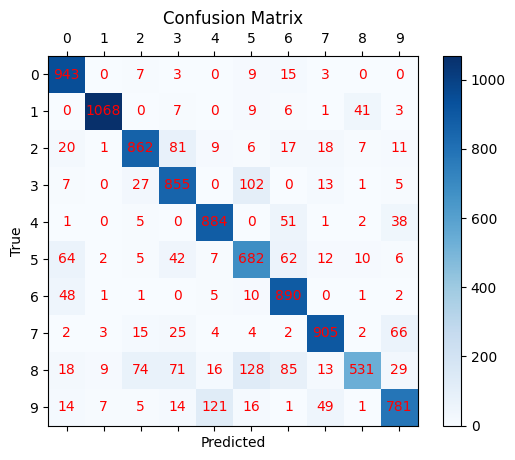

Learning Rate: 0.11, Hidden Layer Size: 16, Epochs: 32, 
Final Training Loss: 0.28530887460288906, Final Testing Loss: 0.4259511963087885, Final Accuracy: 86.79%
 


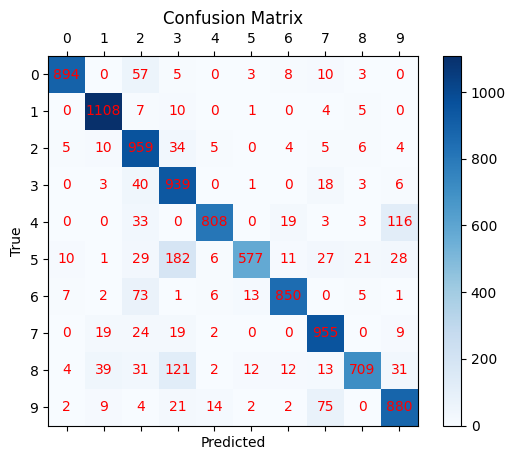

Learning Rate: 0.11, Hidden Layer Size: 32, Epochs: 32, 
Final Training Loss: 0.23325971899723064, Final Testing Loss: 0.2589597743893349, Final Accuracy: 92.55%
 


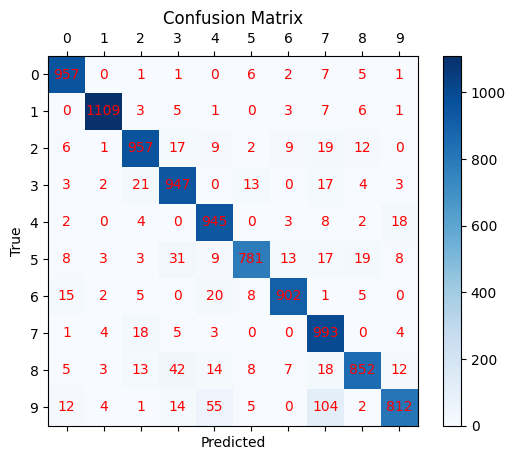

Learning Rate: 0.33, Hidden Layer Size: 8, Epochs: 32, 
Final Training Loss: 0.6966869617128997, Final Testing Loss: 0.7549615131867867, Final Accuracy: 72.91%
 


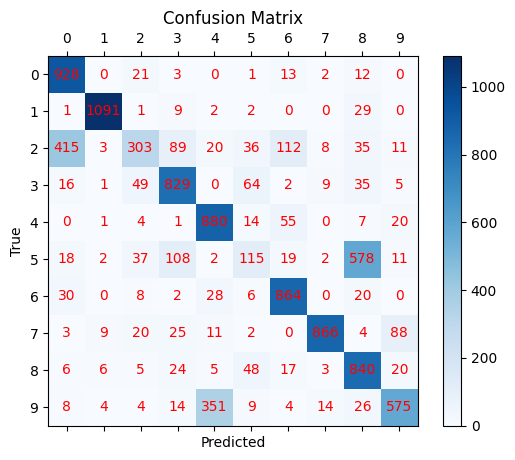

Learning Rate: 0.33, Hidden Layer Size: 16, Epochs: 32, 
Final Training Loss: 0.31405355279116737, Final Testing Loss: 0.41257990467689043, Final Accuracy: 88.1%
 


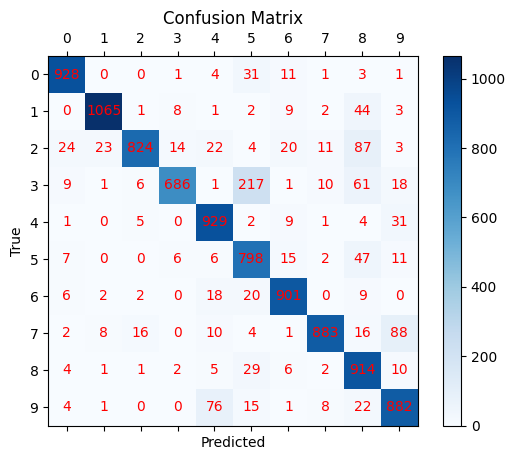

Learning Rate: 0.33, Hidden Layer Size: 32, Epochs: 32, 
Final Training Loss: 0.25982079207312736, Final Testing Loss: 0.32309285639422786, Final Accuracy: 91.01%
 


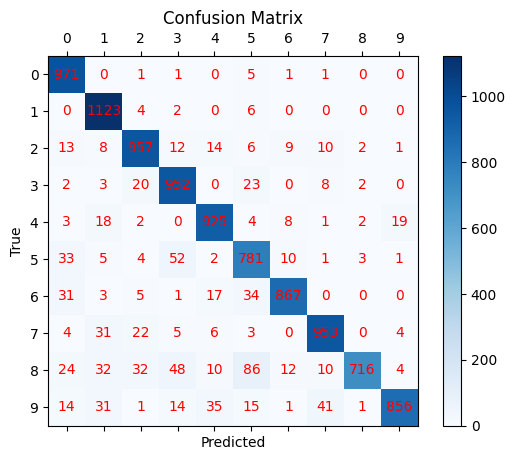

Learning Rate: 0.66, Hidden Layer Size: 8, Epochs: 32, 
Final Training Loss: 1.5318687954912935, Final Testing Loss: 1.7971882800695789, Final Accuracy: 25.66%
 


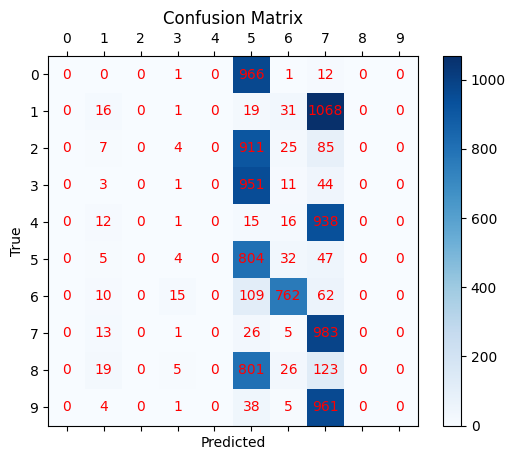

Learning Rate: 0.66, Hidden Layer Size: 16, Epochs: 32, 
Final Training Loss: 1.3491380562620814, Final Testing Loss: 1.5432677529865018, Final Accuracy: 27.650000000000002%
 


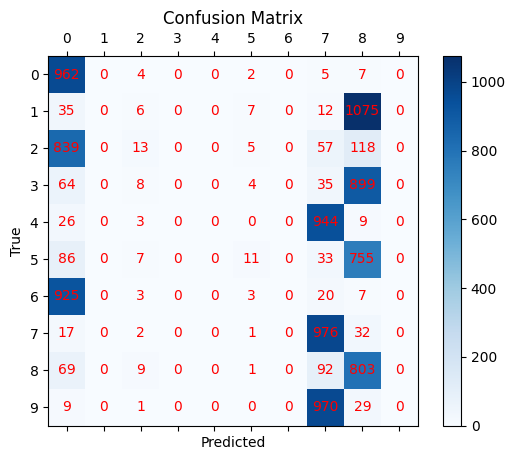

Learning Rate: 0.66, Hidden Layer Size: 32, Epochs: 32, 
Final Training Loss: 0.5674100900345387, Final Testing Loss: 0.5934469364590218, Final Accuracy: 81.21000000000001%
 


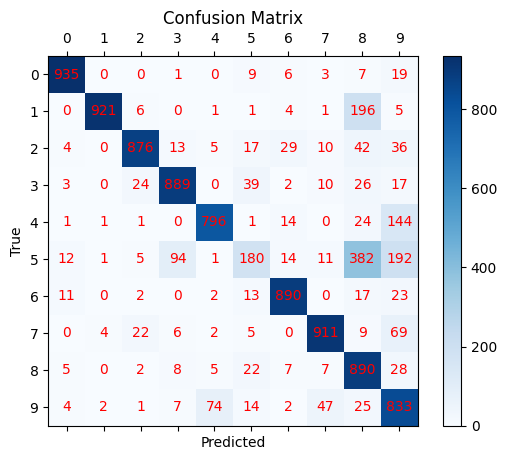

In [170]:
learning_rates = np.array([0.11, 0.33, 0.66])
hidden_sizes = np.array([8, 16, 32])

r_learning_rates = []
r_hidden_sizes = []
r_training_losses = []
r_testing_losses = []
r_accuracies = []

for learning_rate in learning_rates:
    for hidden_size in hidden_sizes:
        training_losses, testing_losses, accuracies = train_with_epoch(hidden_size=hidden_size, learning_rate=learning_rate)
        r_learning_rates.append(learning_rate)
        r_hidden_sizes.append(hidden_size)
        r_training_losses.append(training_losses)
        r_testing_losses.append(testing_losses)
        r_accuracies.append(accuracies)


### Evaluierung der Netzwerke

Um die Effizienz verschiedener Konfigurationen eines neuronalen Netzwerks zu beurteilen, wurden Experimente mit variierenden Lernraten und Grössen der verborgenen Schichten durchgeführt. Die Ergebnisse dieser Konfigurationen wurden visuell gegenübergestellt, um die Auswirkungen auf den Trainings- und Testverlust sowie auf die Genauigkeit über mehrere Epochen hinweg zu vergleichen.

**Vergleich der Trainings- und Testverluste:**
Durch die Darstellung der Trainingsverluste kann festgestellt werden, wie schnell und effektiv ein Netzwerkmodell von den Trainingsdaten lernt. Geringere Verluste deuten auf ein besseres Lernen hin, während höhere Verluste auf Schwierigkeiten bei der Modellanpassung hinweisen könnten. Ähnlich gibt der Testverlust Aufschluss darüber, wie gut das Modell auf unbekannten Daten generalisiert.

**Analyse der Genauigkeit:**
Die Genauigkeit ist ein kritischer Indikator für die Leistungsfähigkeit des Modells, besonders in Klassifikationsaufgaben. Eine höhere Genauigkeit zeigt an, dass das Modell effektiv Muster und Beziehungen in den Daten erkannt hat und diese erfolgreich auf neue, ungesichtete Daten anwenden kann. Die Genauigkeit wurde für jede Konfiguration über die Epochen hinweg verfolgt, um zu beobachten, wie sich die Modellleistung mit fortschreitendem Training entwickelt.

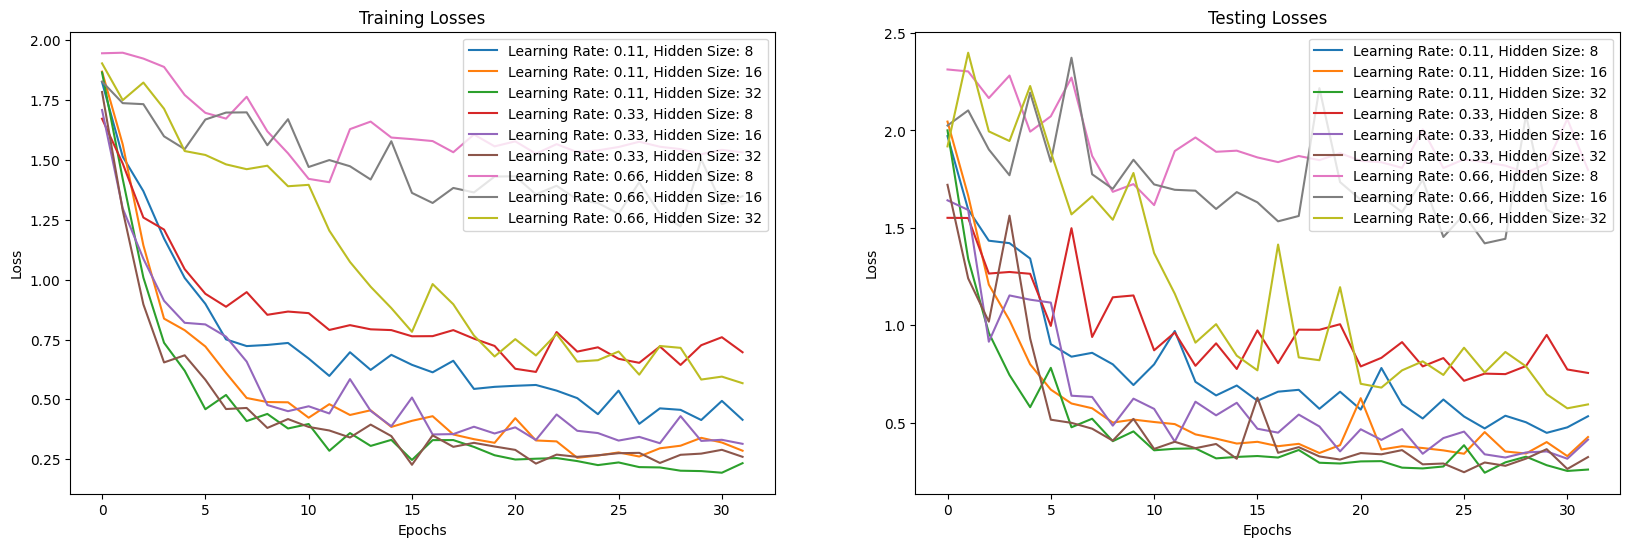

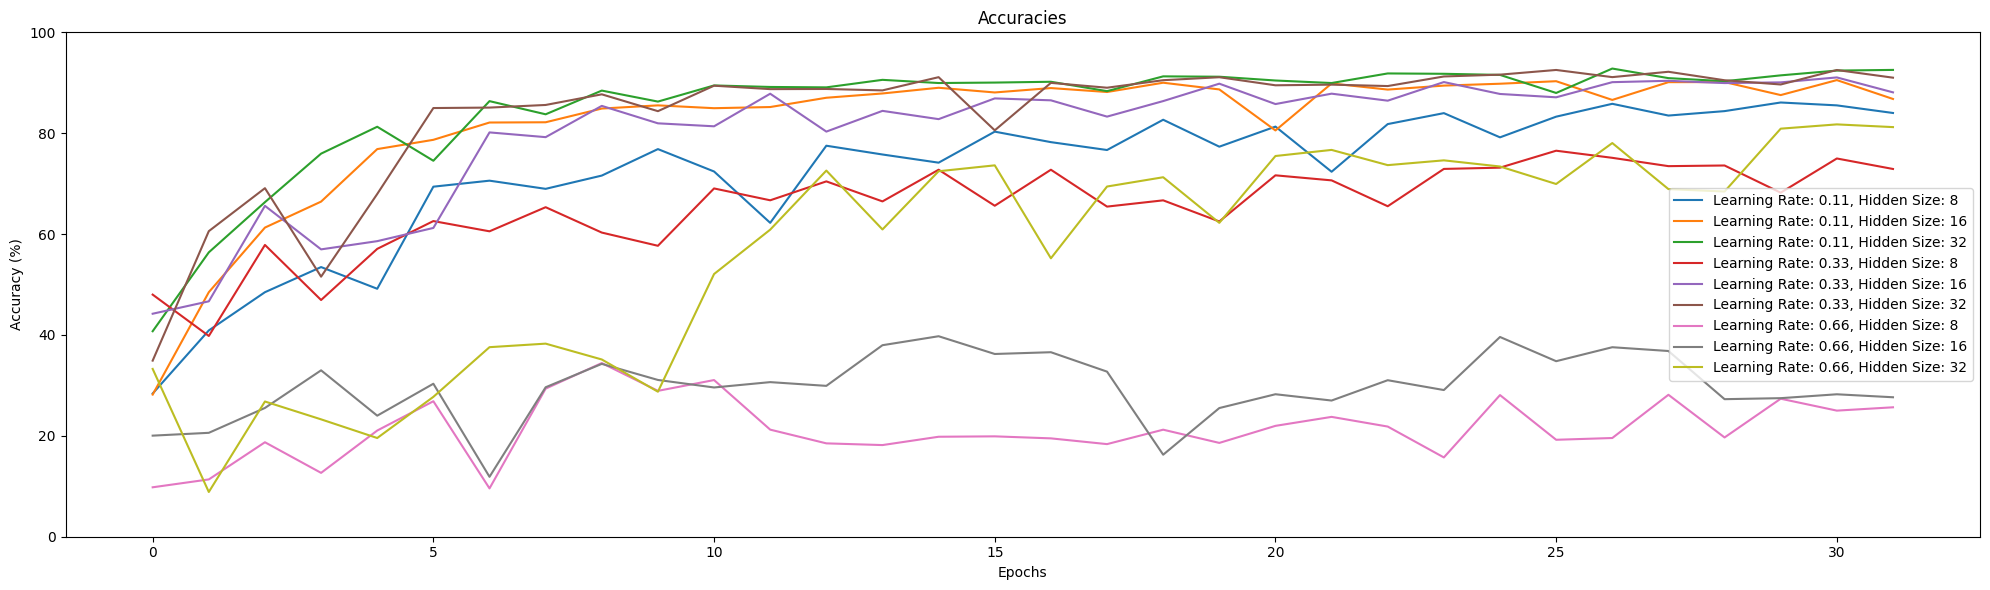

In [171]:
plt.figure(figsize=(20, 6))

for i in range(len(r_learning_rates)):
    label = f'Learning Rate: {r_learning_rates[i]}, Hidden Size: {r_hidden_sizes[i]}'

    plt.subplot(1, 2, 1)
    plt.plot(r_training_losses[i], label=label)
    plt.title('Training Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(r_testing_losses[i], label=label)
    plt.title('Testing Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plt.figure(figsize=(20, 6))

for i in range(len(r_learning_rates)):
    label = f'Learning Rate: {r_learning_rates[i]}, Hidden Size: {r_hidden_sizes[i]}'

    plt.plot(r_accuracies[i], label=label)
    plt.title('Accuracies')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.ylim(0, 100) 
    plt.legend()

plt.tight_layout()
plt.show()


Von den getesteten Konstellationen scheint die Kombination aus der Learning Rate von 0.11 und der Hidden Size von 32 am zuverlässigsten sehr gute Ergebnisse zu erzielen.


## Zusammenfassung

In diesem Jupyter Notebook haben wir uns intensiv mit dem Gradient Descent Verfahren beschäftigt, um zu lernen, wie man numerische Methoden auf komplexe Probleme anwendet. Am Beispiel des MNIST-Datasets, das handgeschriebene Ziffern enthält, haben wir zuerst die Daten genau analysiert. Ein wichtiger Punkt war hier, dass nicht alle Ziffern gleich oft vorkommen, was das Training des neuronalen Netzwerks erschwerte.

Wir haben ein neuronales Netzwerk Schritt für Schritt aufgebaut und verbessert, das mehrere Schichten umfasste, um die Bilder zu erkennen. Ein großes Problem beim Trainieren des Netzwerks war, dass es manchmal nicht besser wurde. Also haben wir das Training in kleinere Teile aufgeteilt, was geholfen hat. Techniken wie Klassengewichtung und der vermehrte Einsatz von seltenen Daten waren wichtig, um das Netzwerk besser zu trainieren.

Neben der praktischen Umsetzung haben wir auch die Theorie hinter dem Gradient Descent ausführlich besprochen. Das umfasste die mathematischen Grundlagen und wie diese in der Praxis angewendet werden, um Modelle zu verbessern.

Diese Arbeit demonstriert, wie mithilfe von neuronalen Netzwerken und dem Gradient Descent Verfahren komplexe Probleme in der Bildklassifikation gelöst werden können, wobei die Lösungsansätze je nach Problemstellung variieren können.

Chat-GPT 4.0 wurde für verschiedene Aspekte dieser Arbeit verwendet:
* Recherche um die Aufgabenstellung zu verstehen.
* Evaluieren welche Aktivierungs-, Verlust- und Evaluationsfunktionen implementiert werden sollen.
* Generierung der Plots
* Generierung der Code Dokumentation
* Fehlersuche im Code
* Korrektur der Texte.

Der Code wurde sonst immer zuerst von Hand erstellt und dann mit der Hilfe von Chat-GPT verbessert und auf Fehler überprüft.
